### Import Necessary Libraries and Modules

In [1]:
from tqdm import tqdm
from IPython.display import clear_output

import torch

# Custom module imports
from networks import UNet
from data_processing import get_dataloader
from viz import viz_batch, viz_forward_diffusion, viz_inference_steps, plot_loss_and_lr
from ddpm import create_linear_schedule, ddpm_forward, ddpm_inference

### Set Hyperparameters and Configuration

In [2]:
# Paths and Data Parameters
DATA_PATH = "D:/files"  # Directory for the dataset
IMG_SIZE = 64  # Image dimensions
BATCH_SIZE = 100  # Number of samples per batch

# Noise Schedule Parameters
BETA_START = 0.0001  # Starting value of beta for the noise schedule
BETA_END = 0.02  # Ending value of beta
T = 512  # Total number of diffusion steps

# Network Architecture Parameters
CH_MULTS = (1, 2, 1, 1)  # Channel multipliers for the UNet architecture

# Training Parameters
NUM_EPOCHS = 5  # Total number of epochs
BASE_LR = 0.0006  # Base learning rate
T_MAX = NUM_EPOCHS  # Number of epochs for one cycle in Cosine Annealing
WARMUP_EPOCHS = 2  # Number of warm-up epochs with a linear learning rate increase

# Use the following hyperparameters for extremely long training
# CH_MULTS = (1, 2, 2, 2)
# NUM_EPOCHS = 300
# BASE_LR = 0.0001
# T_MAX = NUM_EPOCHS
# WARMUP_EPOCHS = 10

### Visualize Sample Batch from the Dataset

Size of the dataset: 16185
Using 12 workers


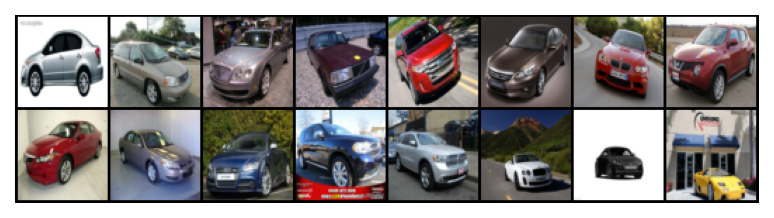

In [3]:
# Load data and get a sample batch
dataloader = get_dataloader(path=DATA_PATH, image_size=IMG_SIZE, batch_size=BATCH_SIZE, num_samples=500)
sample_batch, _ = next(iter(dataloader))

# Visualize a few samples from the batch
num_samples_to_visualize = 16
viz_batch(sample_batch[:num_samples_to_visualize], dpi=150)

### Create Noise Schedule and Visualize Forward Diffusion

torch.Size([4, 8, 3, 64, 64])


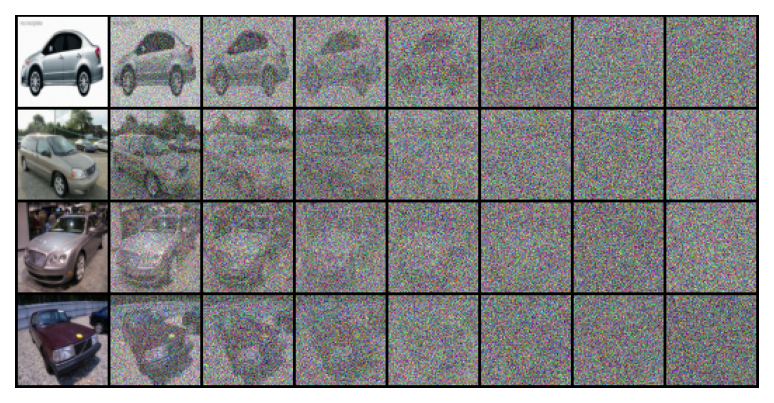

In [4]:
# Determine the device (CPU or GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create a linear noise schedule
noise_schedule = create_linear_schedule(start=BETA_START, end=BETA_END, num_timesteps=T, device=device)

# Visualize the forward diffusion process
num_samples_to_diffuse = 4
sample_images = sample_batch[:num_samples_to_diffuse].to(device)
viz_forward_diffusion(sample_images, T, noise_schedule, num_checkpoints=7, interleave=False, dpi=150, device=device)

### Initialize Model, Loss Function, Optimizer, and Scheduler

In [5]:
# Initialize the UNet model
model = UNet(ch_mults=CH_MULTS).to(device)
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters in the model: {num_params:,}")

# Define the loss function
criterion = torch.nn.MSELoss()

# Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=BASE_LR)

# Set up a learning rate scheduler with Cosine Annealing
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=T_MAX - WARMUP_EPOCHS,  # Total steps after warm-up
    eta_min=BASE_LR / 10         # Minimum learning rate
)

Number of parameters in the model: 9,136,835


### Train the Model

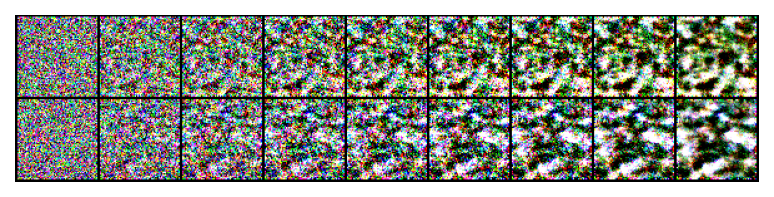

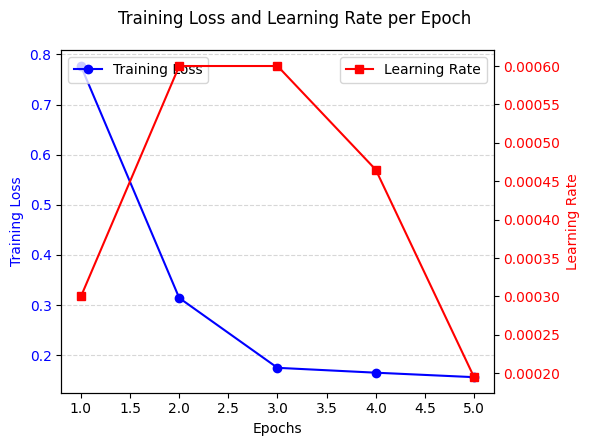

Epoch 5/5, Loss: 0.1561, Learning Rate: 0.000195


In [6]:
# Parameters for visualization during training
viz_interval = 1  # How often to visualize inference results (in epochs)
num_visualization_images = 2  # Number of images to visualize during inference
fixed_noises = torch.randn((num_visualization_images, 3, IMG_SIZE, IMG_SIZE), device=device)

# Lists to track learning rate and loss over epochs
learning_rates = []
epoch_losses = []

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0

    # Adjust learning rate
    if epoch < WARMUP_EPOCHS:
        # Linear warm-up phase
        current_lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
    else:
        # Cosine annealing phase
        current_lr = scheduler.get_last_lr()[0]
        scheduler.step()
    learning_rates.append(current_lr)

    # Training loop
    for batch, _ in tqdm(dataloader):
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Sample random timesteps for each image
        batch_size = batch.shape[0]
        timesteps = torch.randint(0, T, (batch_size,), device=device).long()
        
        # Apply forward diffusion
        noisy_images, noise_targets = ddpm_forward(batch, timesteps, noise_schedule, device=device)
        
        # Predict noise with the UNet
        predicted_noise = model(noisy_images, timesteps)
        loss = criterion(noise_targets, predicted_noise)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Compute and store average loss for the epoch
    average_loss = running_loss / len(dataloader)
    epoch_losses.append(average_loss)

    # Visualize and log progress
    if epoch % viz_interval == 0:
        clear_output(wait=True)

        inference_image_path = f"ddpm_output/frame_{(epoch + 1):05d}.png"
        performance_plot_path = f"ddpm_output/perf_plot.png" if epoch == NUM_EPOCHS - 1 else None
        viz_inference_steps(fixed_noises, model, noise_schedule, inference_image_path, device)
        plot_loss_and_lr(epoch_losses, learning_rates, performance_plot_path)

    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Loss: {average_loss:.4f}, Learning Rate: {current_lr:.6f}")

### Generate New Samples from Noise

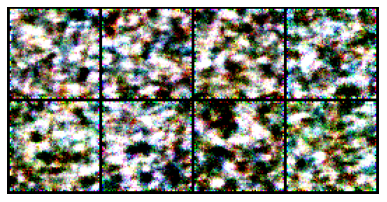

In [7]:
# Generate images from random noise using the trained model
num_generated_images = 8
input_noise = torch.randn((num_generated_images, 3, IMG_SIZE, IMG_SIZE), device=device)
generated_images = ddpm_inference(input_noise, model, noise_schedule, return_all=False, device=device)

# Visualize the generated images
viz_batch(generated_images, nrow=4, dpi=75)